# Model MobileNetV2

In [2]:
# Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2

### Some useful parameters for the model

In [3]:
# Parameters
img_height = 100
img_width = 100
batch_size = 64
num_classes = 131
epochs = 15

### Preparing Data

In [4]:
# Generators for our data
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'C:/Users/Palmg/Desktop/fruits-360/Test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


### Training image sample

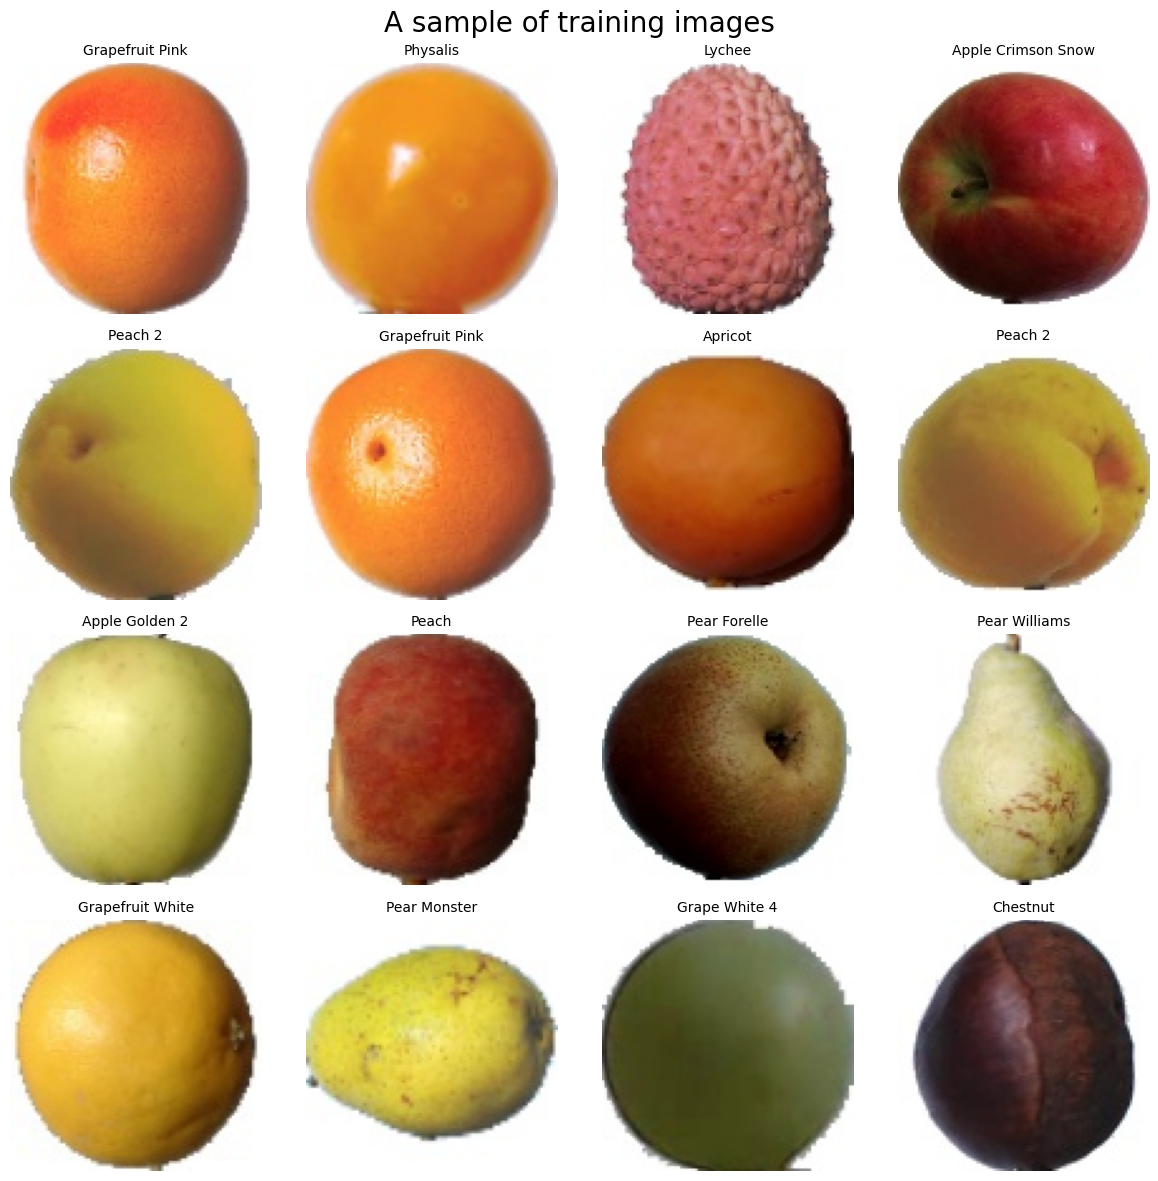

In [5]:
# Extracts a batch of train images and labels.
# The labels are one-hot encoded so we transform that to index [0,130] instead using argmax()
train_images, train_labels = next(train_generator)
train_classes = np.argmax(train_labels, axis=1)

# Define a list of class labels. These are written labels like "Orange" and "Mandarine"
class_labels = list(train_generator.class_indices.keys())

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('A sample of training images', fontsize=20)

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i])
    ax.axis('off')
    ax.set_title(class_labels[train_classes[i]], fontsize=10)
plt.tight_layout()
plt.show()

### Defining MobileNetV2 model

In [6]:
# The pre-trained model
base_mobilenetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_mobilenetV2.trainable = False

# Build the model
model = Sequential()

model.add(base_mobilenetV2)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 512)               10486272  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 131)               67203     
                                                                 
Total params: 12,811,459
Trainable params: 10,553,475
Non-trainable params: 2,257,984
____________________________________

### Training

In [7]:
"""
Callback function to run all 15 epochs but then afterwards choose the best weights. (Best performing model)
Earlier version stopped training if the last 5 epochs were not improving the accuracy by at least 1%.
I decided that I want to see the whole training through.
"""
callback = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    min_delta=0.005,
    restore_best_weights=True
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/15
847/847 [==============================] - 406s 477ms/step - loss: 1.0641 - accuracy: 0.7369 - val_loss: 0.1245 - val_accuracy: 0.9657
Epoch 2/15
847/847 [==============================] - 180s 213ms/step - loss: 0.3920 - accuracy: 0.8853 - val_loss: 0.1786 - val_accuracy: 0.9649
Epoch 3/15
847/847 [==============================] - 184s 218ms/step - loss: 0.3456 - accuracy: 0.9037 - val_loss: 0.2286 - val_accuracy: 0.9652
Epoch 4/15
847/847 [==============================] - 183s 216ms/step - loss: 0.3355 - accuracy: 0.9112 - val_loss: 0.1333 - val_accuracy: 0.9739
Epoch 5/15
847/847 [==============================] - 184s 217ms/step - loss: 0.2914 - accuracy: 0.9271 - val_loss: 0.1863 - val_accuracy: 0.9719
Epoch 6/15
847/847 [==============================] - 185s 219ms/step - loss: 0.3143 - accuracy: 0.9276 - val_loss: 0.2291 - val_accuracy: 0.9707
Epoch 7/15
847/847 [==============================] - 184s 217ms/step - loss: 0.2872 - accuracy: 0.9362 - val_loss: 0.2208 -

In [8]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_accuracy = history.history['val_accuracy'][best_epoch - 1]
best_accuracy = history.history['accuracy'][best_epoch - 1]

# Print the results
print("MobileNetV2 Stats", "\n")

print(f"Best Epoch was: {best_epoch}")
print(f"Accuracy: {best_accuracy}")
print(f"Validation Accuracy: {best_val_accuracy}")

MobileNetV2 Stats 

Best Epoch was: 9
Accuracy: 0.938992440700531
Validation Accuracy: 0.9742260575294495


### Plotting the training progress

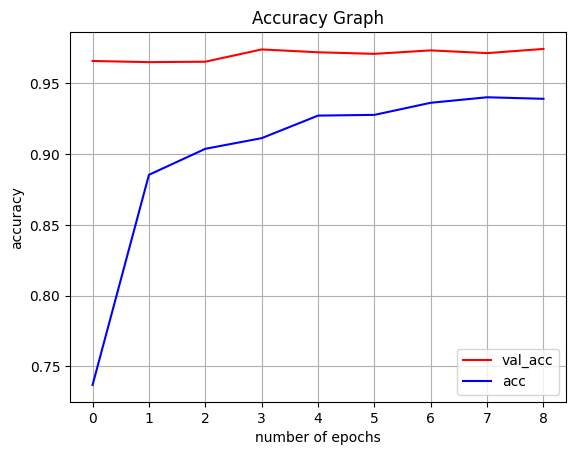

In [9]:
"""
Plotting validation accuracy and accuracy.
If validation accuracy is higher than plain accuracy its good.
Other way around it means the model is overfitting.
"""
plt.plot(history.history["val_accuracy"],color="r",label="val_acc")
plt.plot(history.history["accuracy"], color="b", label="acc" )
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

### Saving Model

In [10]:
model.save("/Users/Palmg/Desktop/machineLearningModels/mobileNetV2_BSc_model.h5")

### Loading Model

In [11]:
model = load_model("/Users/Palmg/Desktop/machineLearningModels/mobileNetV2_BSc_model.h5")

### MobileNetV2 Predictions

2/2 [==============================] - 0s 73ms/step
<class 'numpy.ndarray'> (64, 131)
<class 'numpy.ndarray'> (64,)
84
84


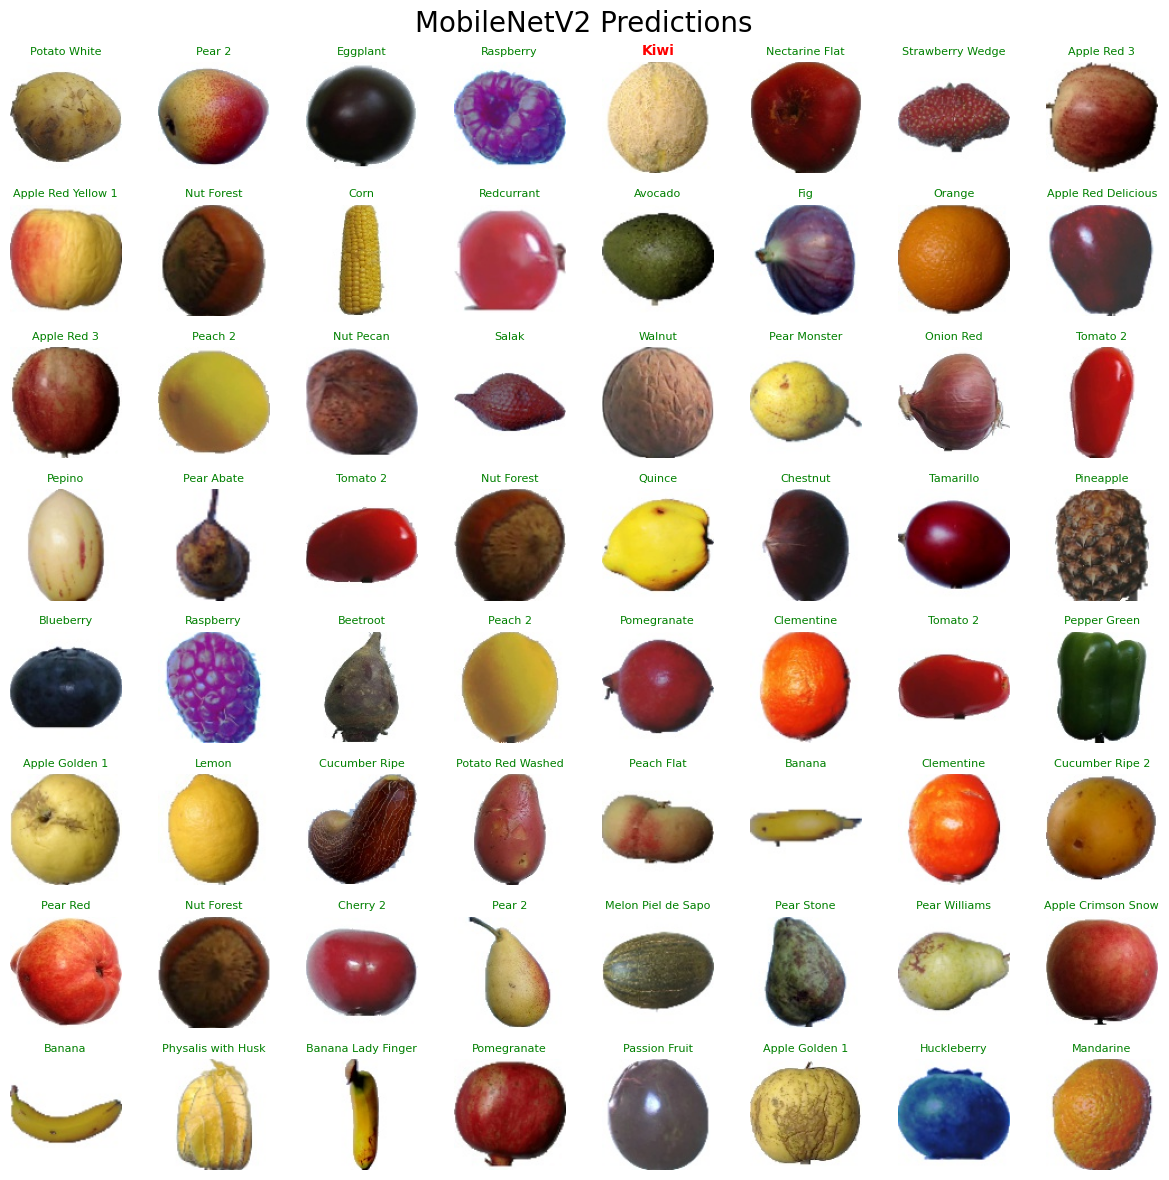

In [13]:
# Extracts a batch of test images and labels.
# The labels are one-hot encoded so we transform that to index [0,130] instead using argmax()
test_images, test_labels = next(test_generator)
test_classes = np.argmax(test_labels, axis=1)

# Get predictions for a batch of test images.
# Again we only want the index of the most probable fruit [0,130]
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)

# Define a list of class labels
class_labels = list(test_generator.class_indices.keys())

print(type(test_labels), test_labels.shape)
print(type(pred_classes), pred_classes.shape)
print(test_classes[1])
print(pred_classes[1])

"""
Create a 4x4 subplot of images and their predicted classes.

Labels are colored:
Green if prediction was correct
Red if prediction was wrong

Also added some extra fontweight + slightly bigger font to wrong predictions.
I want them to stand out
"""
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.suptitle('MobileNetV2 Predictions', fontsize=20)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i])
    ax.axis('off')
    if class_labels[test_classes[i]] == class_labels[pred_classes[i]]:
        ax.set_title(class_labels[pred_classes[i]], fontsize=8, color='green')
    else:
        ax.set_title(class_labels[pred_classes[i]], fontsize=10, color='red', fontweight='bold')
plt.tight_layout()
plt.show()